# Predicting 

In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("insurance.csv")

display(data.head())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [225]:
data.replace({})
data = data.replace(['yes','no'], [1,0])
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520
5,31,female,25.740,0,0,southeast,3756.62160
6,46,female,33.440,1,0,southeast,8240.58960
7,37,female,27.740,3,0,northwest,7281.50560
8,37,male,29.830,2,0,northeast,6406.41070
9,60,female,25.840,0,0,northwest,28923.13692


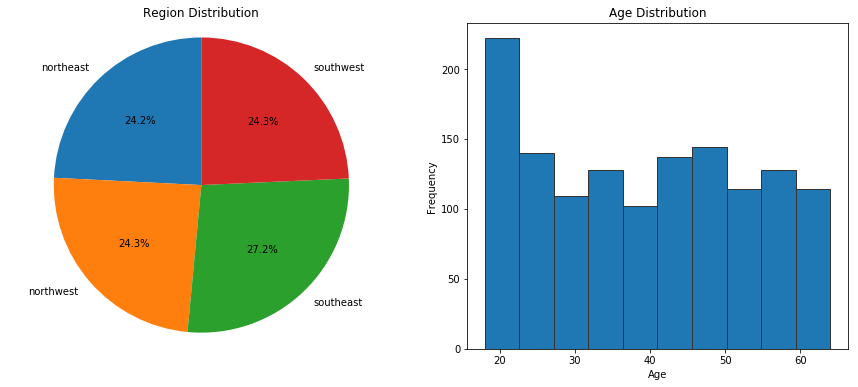

In [226]:
fig1, (ax11,ax12) = plt.subplots(1,2)
fig1.set_size_inches(15,6)
sizes = data.groupby("region").size().values
labels = data.groupby('region').size().keys()

ax11.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax11.set_title("Region Distribution")
ax12.hist('age', bins=10,data=data,edgecolor='0.2')
ax12.set_ylabel("Frequency")
ax12.set_xlabel("Age")
ax12.set_title("Age Distribution")
regionchart= ax11.axis('equal')

Text(0,0.5,'Frequency')

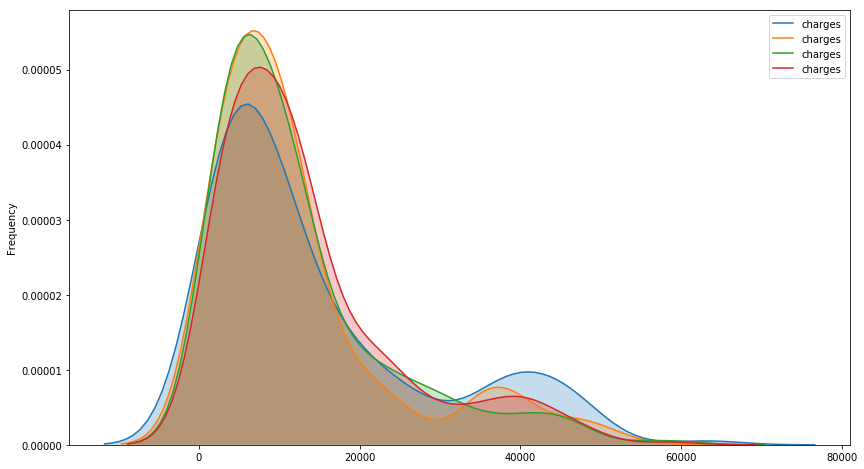

In [99]:
southeast_dens = data.loc[data["region"] == 'southeast']
southwest_dens = data.loc[data["region"] == 'southwest']
northwest_dens = data.loc[data["region"] == 'northwest']
northeast_dens = data.loc[data["region"] == 'northeast']

fig2, ax2 = plt.subplots()
fig2.set_size_inches(14,8)
sns.kdeplot(southeast_dens["charges"], ax=ax2, shade=True)
sns.kdeplot(southwest_dens["charges"], ax=ax2, shade=True)
sns.kdeplot(northwest_dens["charges"], ax=ax2, shade=True)
sns.kdeplot(northeast_dens["charges"], ax=ax2, shade=True)
ax2.set_ylabel("Frequency")

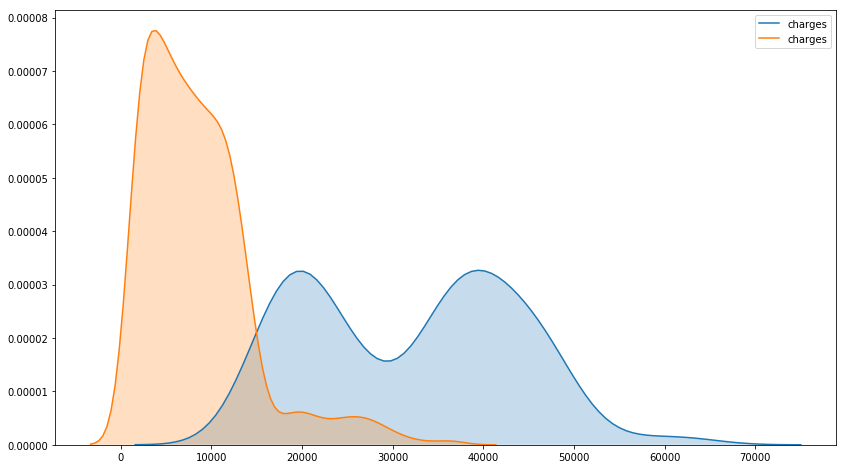

In [180]:
smoker_data = data.loc[data['smoker'] == 'yes']
nonsmoker_data = data.loc[data['smoker'] == 'no']
fig3, ax3 = plt.subplots()
fig3.set_size_inches(14,8)
sns.kdeplot(smoker_data["charges"], ax=ax3, shade=True)
sns.kdeplot(nonsmoker_data["charges"], ax=ax3, shade=True)

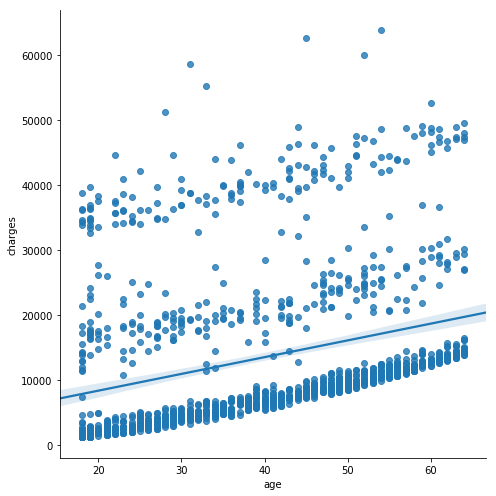

In [111]:
sns.lmplot("age", "charges", data, size=7)

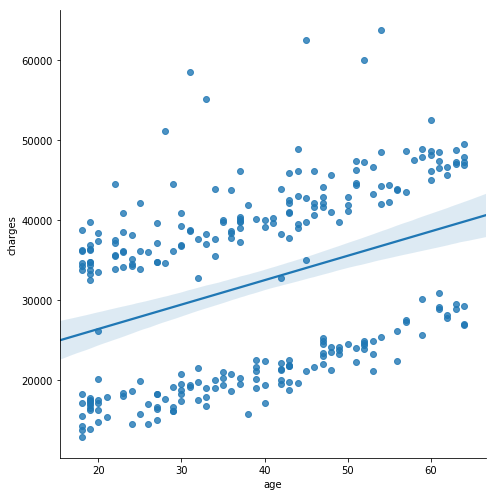

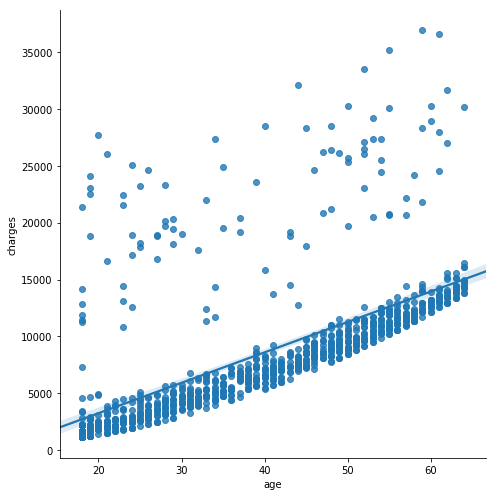

In [114]:
sns.lmplot("age", "charges", smoker_data, size = 7)
sns.lmplot("age", "charges", nonsmoker_data, size = 7)

In [135]:
display(smoker_data.loc[smoker_data["charges"] > 30000].groupby("sex").count())
display(data.groupby("sex").count())

,age,bmi,children,smoker,region,charges
sex,,,,,,
female,54,54,54,54,54,54
male,98,98,98,98,98,98


,age,bmi,children,smoker,region,charges
sex,,,,,,
female,662,662,662,662,662,662
male,676,676,676,676,676,676


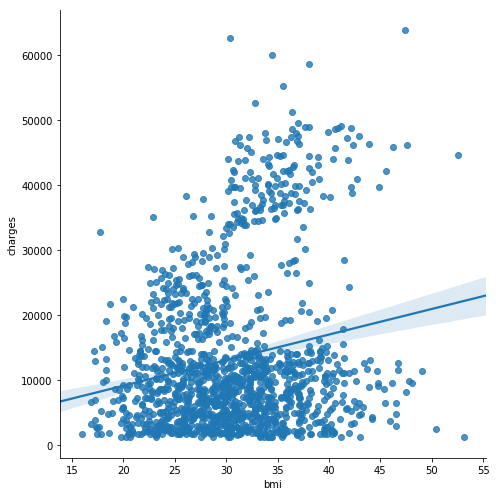

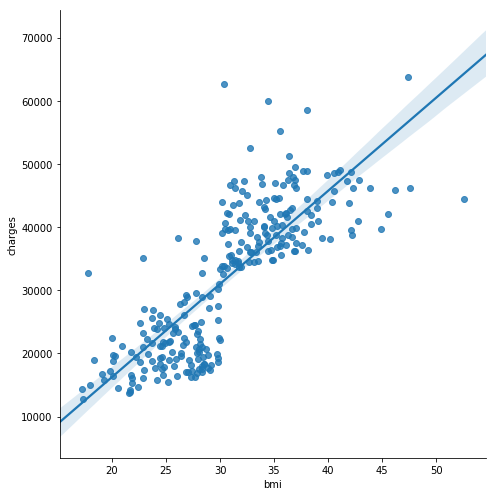

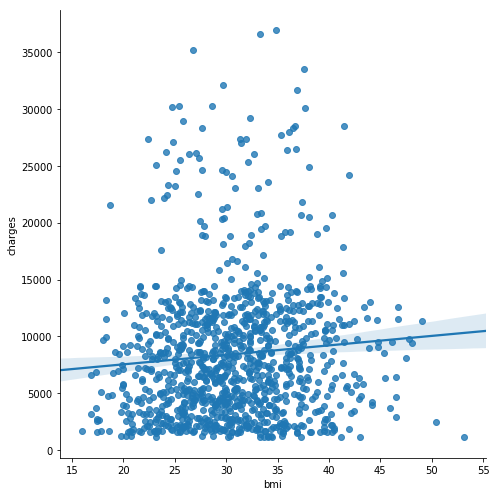

In [137]:
sns.lmplot("bmi", "charges", data, size=7)
sns.lmplot("bmi", "charges", smoker_data, size = 7)
sns.lmplot("bmi", "charges", nonsmoker_data, size = 7)

In [227]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = data.drop(['charges','sex','region','children'], axis=1)
Y = data["charges"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)



X_s_train = X_test.loc[X_test['smoker'] == 'yes'].drop('smoker', axis=1)
X_n_train = X_test.loc[X_test['smoker'] == 'no'].drop(['smoker','bmi'], axis=1)
Y_s_train = Y_test.loc[X_test['smoker'] == 'yes']
Y_n_train = Y_test.loc[X_test['smoker'] == 'no']


smokermodel = LinearRegression()
smokermodel.fit(X_s_train,Y_s_train)
nonsmokermodel = LinearRegression()
nonsmokermodel.fit(X_n_train,Y_n_train)
print(X_train.columns)
def predictor(df):
    smokers = df[df['smoker']=='yes']
#     display(smokers)
    non_smokers = df[df['smoker']=='no']
    smokers['prediction'] = smokermodel.predict(smokers[['age','bmi']])
    non_smokers['prediction']= nonsmokermodel.predict(non_smokers[['age']])
    frames = [smokers, non_smokers]
    return  pd.concat(frames)

predictions_combined_df = predictor(X_test[['age','bmi','smoker']])
display(X_test.head())
predictions_combined_df.head()
# print("Accuracy score")
# print(r2_score(predictions_combined_df['prediction'].values,Y_test))

e:\python27\lib\site-packages\pandas\core\ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

In [231]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth=10,min_samples_split=3,max_leaf_nodes=10)
clf.fit(X_train,Y_train)
predictions = clf.predict(X_test)
r2_score(predictions,Y_test)

0.8229919756015871